In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def write_spikes_to_disk(path, metadata, train, train_labels, train_gunshot_data, val, val_labels, val_gunshot_data,
val_filenames, test, test_labels):
    np.savez(path, metadata=metadata, train_set=train, validation_set=val, test_set=test, train_labels=train_labels,
            validation_labels=val_labels, test_labels=test_labels, train_gunshot_data=train_gunshot_data,
            validation_gunshot_data=val_gunshot_data, validation_filenames=val_filenames)

def read_spikes_from_disk(path):
    data = np.load(path)

    # compatability with old datasets
    val_filenames = []
    if 'validation_filenames' in data:
        val_filenames = data['validation_filenames']

    return data['train_set'], data['train_labels'], data['train_gunshot_data'], data['validation_set'], data['validation_labels'], data['validation_gunshot_data'], val_filenames, data['test_set'], data['test_labels']

# Encoding Methods
Make sure to read_spikes_from_disk using appropriate dataset for encoding.
Each cell is an encoding type, only run one.

In [3]:
# for now let's take the output from snn/make_dataset.py
# it generates a DWT spectrogram matrix that is normalized to 0-1

training_data, training_labels, training_gunshot_data, validation_data, validation_labels, validation_gunshot_data, validation_filenames, test_data, test_labels = read_spikes_from_disk('../snn/data/5000-spec-nr.npz')

In [ ]:
# S2S ENCODING
# temporary function just to convert data from s2s format from make_data.py to snntorch format
def parse_s2s(d):
    all_samples = []
    for sample in d:
        channels = []
        for channel in sample:
            channels.append([])
            for timestep in channel:
                channels[-1].append(timestep[2])
        all_samples.append(channels)

    return torch.tensor(all_samples, dtype=torch.float32).permute(2, 0, 1)

dm_train_data = parse_s2s(training_data)
dm_val_data = parse_s2s(validation_data)

In [4]:
### DELTA MOD - 1 POSITIVE AND 1 NEGATIVE CHANNEL PER FREQ BAND
# input is shape time x batch x channels (from spectrogram or dwt spec)
def posneg_delta(raw_spec_data):
    delta = spikegen.delta(raw_spec_data, threshold=0.001, off_spike=True)
    
    new_data = torch.zeros(delta.shape[0], delta.shape[1], delta.shape[2]*2) # 2 channels for each freq channel
    for i in range(delta.shape[1]): # for each sample
        for timestep in range(delta.shape[0]):
            for channel in range(delta.shape[2]):
                if delta[timestep, i, channel] == 1:
                    new_data[timestep, i, channel] = 1
                elif delta[timestep, i, channel] == -1:
                    new_data[timestep, i, channel+delta.shape[2]] = 1;

    return new_data
    

training_data = torch.tensor(training_data)
training_data = training_data.permute(2, 0, 1) 
training_data = posneg_delta(training_data)


val_data = torch.tensor(validation_data)
val_data = val_data.permute(2, 0, 1) 
val_data = posneg_delta(val_data)

test_data = torch.tensor(test_data)
test_data = test_data.permute(2, 0, 1)
test_data = posneg_delta(test_data)

#write to disk for training
metadata = ['dm-threshold: 0.001', 'mode: spec', 'format: snntorch']
write_spikes_to_disk('./data/5000-spec-pndm.npz', metadata, training_data, training_labels, training_gunshot_data,
    val_data, validation_labels, validation_gunshot_data, validation_filenames, test_data, test_labels)

In [ ]:
# DELTA MOD - POSITIVE CHANNEL ONLY

training_data = torch.tensor(training_data)
training_data = training_data.permute(2, 0, 1) 

# note: delta expects shape (timestep, batch, neuron), also used for input to snn
dm_train_data = spikegen.delta(training_data, threshold=0.0075)

# also do for val set
val_data = torch.tensor(validation_data)
val_data = val_data.permute(2, 0, 1) 

# note: delta expects shape (timestep, batch, neuron), also used for input to snn
dm_val_data = spikegen.delta(val_data, threshold=0.0075)

# Visualizations

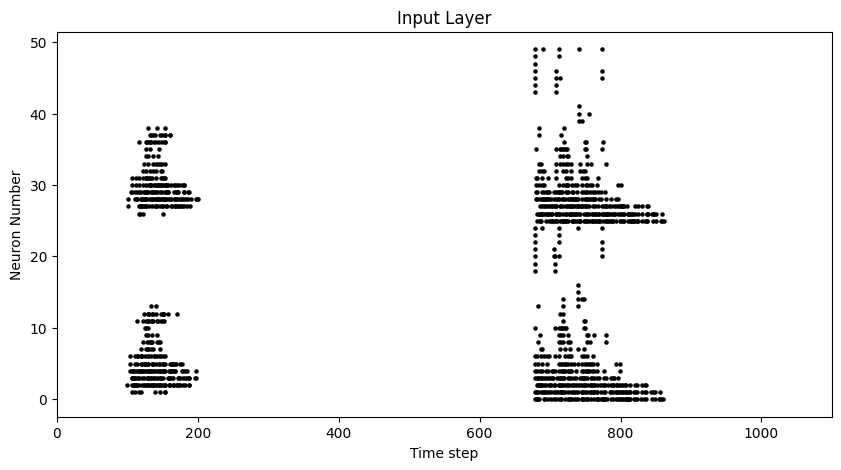

In [40]:
# visualize one sample raster
INDEX = 71
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(training_data[:, INDEX, :], ax, s=5, c="black")


plt.title("Input Layer")
plt.xlabel("Time step")
plt.xlim(0, 1100)
plt.ylabel("Neuron Number")
plt.show()

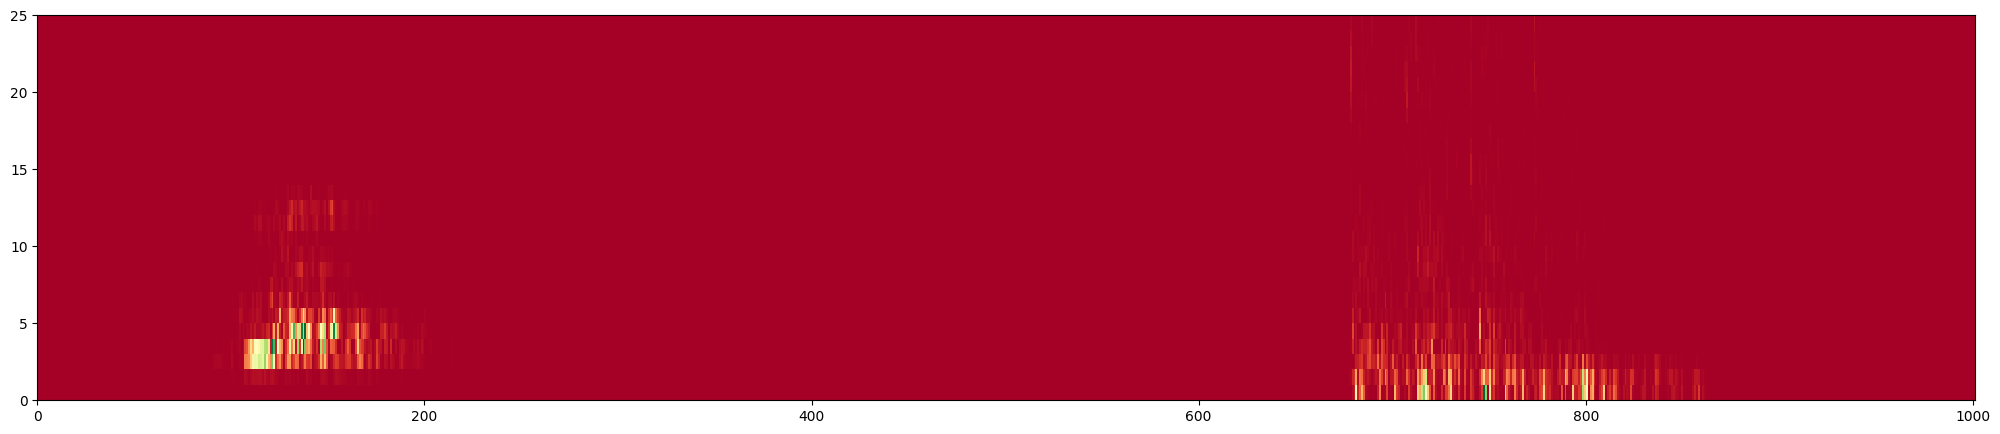

In [41]:
plt.figure(figsize=(25,5))
plt.pcolormesh(read_spikes_from_disk('../snn/data/120-spec-nr.npz')[0][INDEX], cmap='RdYlGn')

In [7]:
# Now the network
# Let's try a FFN
# 7x250x250x2
# see https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html
beta = 0.9 # slow decay
num_timesteps = dm_train_data.shape[0]

class SNN(nn.Module):
    def __init__(self, input_neurons):
        super().__init__()
        self.fc1 = nn.Linear(input_neurons, 250)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(250, 250)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(250, 2)
        self.lif3 = snn.Leaky(beta=beta)

    # x will be (timestep x batch x neuron) shape
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spikes = []
        mem_rec = []

        # Note: one timestep is a full pass
        for step in range(num_timesteps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spikes.append(spk3)
            mem_rec.append(mem3)

        return torch.stack(spikes, dim=0), torch.stack(mem_rec, dim=0)

net = SNN(80).to(device)

In [9]:
# dataset for batches
class SpikesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, index):
        return self.data[:, index, :], self.labels[index]

ds = SpikesDataset(dm_train_data, torch.tensor(training_labels))
loader = DataLoader(ds, batch_size=6, shuffle=True)

In [10]:
# train
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

ds_val = SpikesDataset(dm_val_data, torch.tensor(validation_labels))
val_loader = DataLoader(ds_val, batch_size=6, shuffle=True)

train_loss_log = []
val_loss_log = []
for i in range(1000):
    print(f'Starting epoch {i}.')
        
    # train set run and update
    net.train()
    epoch_losses = []
    for data, labels in loader:
        data = data.to(device)
        labels = labels.to(device)
        
        data = data.permute(1, 0, 2) # permute so we have right shape
        
        spk_rec, mem_rec = net(data)

        # interesting part, we are doing cross entropy loss per timestep here
        loss_val = torch.zeros((1), dtype=torch.float64, device=device)
        for s in range(num_timesteps):
            loss_val += loss(mem_rec[s], labels)
            

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        epoch_losses.append(loss_val.item())

    print(f'Train loss: {sum(epoch_losses)/len(epoch_losses):.2f}')
    train_loss_log.append(sum(epoch_losses)/len(epoch_losses))

    # validation set
    epoch_losses = []
    with torch.no_grad():
        net.eval()

        correct = 0
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)
            
            data = data.permute(1, 0, 2)

            spk_rec, mem_rec = net(data)
            
            # accuracy
            v, ind = spk_rec.sum(dim=0).max(1)
            correct += (labels == ind).sum()

            loss_val = torch.zeros((1), dtype=torch.float64, device=device)
            for s in range(num_timesteps):
                loss_val += loss(mem_rec[s], labels)

            epoch_losses.append(loss_val.item())

        print(f'Val loss: {sum(epoch_losses)/len(epoch_losses):.2f}')
        val_loss_log.append(sum(epoch_losses)/len(epoch_losses))
        print(f'Val accuracy: {(correct/len(ds_val))*100:.2f}')

Starting epoch 0.
Train loss: 206.24
Val loss: 197.89
Val accuracy: 75.00
Starting epoch 1.
Train loss: 201.71
Val loss: 199.39
Val accuracy: 83.33
Starting epoch 2.
Train loss: 201.06
Val loss: 198.60
Val accuracy: 83.33
Starting epoch 3.
Train loss: 201.01
Val loss: 198.31
Val accuracy: 83.33
Starting epoch 4.
Train loss: 201.53
Val loss: 200.94
Val accuracy: 83.33
Starting epoch 5.
Train loss: 200.30
Val loss: 197.64
Val accuracy: 83.33
Starting epoch 6.
Train loss: 199.18
Val loss: 198.46
Val accuracy: 83.33
Starting epoch 7.
Train loss: 196.99
Val loss: 198.44
Val accuracy: 83.33
Starting epoch 8.
Train loss: 195.99
Val loss: 197.07
Val accuracy: 83.33
Starting epoch 9.
Train loss: 194.01


KeyboardInterrupt: 

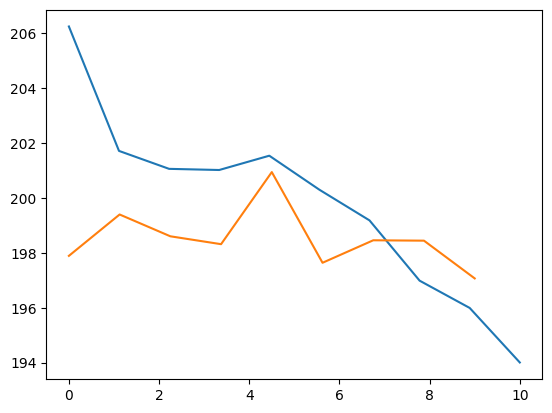

In [11]:
plt.plot(np.linspace(0, len(train_loss_log), len(train_loss_log)), train_loss_log)
plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), val_loss_log)

In [11]:
net.eval()

correct = 0
for data, labels in val_loader:
    print(len(data))
    data = data.to(device)
    labels = labels.to(device)
    
    data = data.permute(1, 0, 2)

    spk_rec, mem_rec = net(data)
    
    # accuracy
    v, ind = spk_rec.sum(dim=0).max(1)
    correct += (labels == ind).sum()

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


In [12]:
print(f'{correct/len(ds_val):.2f}')

0.68
